In [1]:
import os
import re
import copy
import numpy
from IPython.display import Image, display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.data.base import Entry
from rmgpy.data.rmg import RMGDatabase
from rmgpy import settings
from rmgpy.species import Species
from rmgpy.molecule import Molecule
from rmgpy.cantherm.output import prettify

In [2]:
def addThermoData(thermoData1, thermoData2):
    """
    Add the thermodynamic data `thermoData2` to the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] += thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si += thermoData2.H298.value_si
    thermoData1.S298.value_si += thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def removeThermoData(thermoData1, thermoData2):
    """
    Remove the thermodynamic data `thermoData2` from the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] -= thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si -= thermoData2.H298.value_si
    thermoData1.S298.value_si -= thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def averageThermoData(thermoDataset=[]):
    """
    Average a list of thermoData values together.
    Sets uncertainty values to be the approximately the 95% confidence interval, equivalent to
    2 standard deviations calculated using the sample standard variance:
    
    Uncertainty = 2s
    s = sqrt( sum(abs(x - x.mean())^2) / N - 1) where N is the number of values averaged
    
    Note that uncertainties are only computed when number of values is greater than 1.
    """
    
    numValues = len(thermoDataset)
        
    if numValues == 0:
        raise Exception('No thermo data values were inputted to be averaged.')
    else:
        print 'Averaging thermo data over {0} value(s).'.format(numValues)
        
        if numValues == 1:
            return copy.deepcopy(thermoDataset[0])
        
        else:
            averagedThermoData = copy.deepcopy(thermoDataset[0])
            for thermoData in thermoDataset[1:]:
                averagedThermoData = addThermoData(averagedThermoData, thermoData)


            for i in range(averagedThermoData.Tdata.value_si.shape[0]):
                averagedThermoData.Cpdata.value_si[i] /= numValues
                #print averagedThermoData.Cpdata.uncertainty
                cpData = [thermoData.Cpdata.value_si[i] for thermoData in thermoDataset]
                averagedThermoData.Cpdata.uncertainty[i] = 2*numpy.std(cpData, ddof=1)

            HData = [thermoData.H298.value_si for themoData in thermoDataset]
            averagedThermoData.H298.value_si /= numValues
            #print averagedThermoData.H298.getUncertainty()
            #print averagedThermoData.H298.uncertainty
            #print averagedThermoData.H298.uncertainty_si
            averagedThermoData.H298.uncertainty_si = 2*numpy.std(HData, ddof=1)

            SData = [thermoData.S298.value_si for themoData in thermoDataset]
            averagedThermoData.S298.value_si /= numValues
            averagedThermoData.S298.uncertainty_si = 2*numpy.std(SData, ddof=1)
            return averagedThermoData
        
def extractPolycyclicGroups(molecule):
    """
    Extract polycyclic functional groups from a real molecule
    """
    struct = molecule.copy(deep=True)
    
    # Saturate the structure if it is a radical
    if struct.isRadical():
        struct.saturate()
    struct.deleteHydrogens()
    
    polyRings = struct.getPolycyclicRings()
    groups = [convertCycleToGroup(ring) for ring in polyRings]
    
    return groups
                
def convertCycleToGroup(cycle):
    """
    This function converts a list of atoms in a cycle to a functional Group object
    """
    from rmgpy.molecule.group import GroupAtom, GroupBond, Group
    
    # Create GroupAtom object for each atom in the cycle, label the first one in the cycle with a *
    groupAtoms = {}
    bonds = []
    for atom in cycle:
        groupAtoms[atom] = GroupAtom(atomType=[atom.atomType],
                                     radicalElectrons=[0],
                                     label='*' if cycle.index(atom)==0 else '')
                
    group = Group(atoms=groupAtoms.values())            
    
    # Create GroupBond for each bond between atoms in the cycle, but not outside of the cycle
    for atom in cycle:
        for bondedAtom, bond in atom.edges.iteritems():
            if bondedAtom in cycle:
                # create a group bond with the same bond order as in the original molecule,
                # if it hasn't already been created
                if not group.hasBond(groupAtoms[atom],groupAtoms[bondedAtom]):
                    group.addBond(GroupBond(groupAtoms[atom],groupAtoms[bondedAtom],order=[bond.order]))
            else:
                pass
        
    group.update()
    
    return group

In [3]:
def displayThermo(thermoData):
    print 'H298 = {0} kcal/mol'.format(thermoData.H298.value_si/4184)
    print 'S298 = {0} cal/mol*K'.format(thermoData.S298.value_si/4.184)

In [4]:
# Fill in the list of thermo libraries to be used for fitting polycyclic thermo groups
thermoLibraries = ['C10H11']
database = RMGDatabase()
database.load(settings['database.directory'], thermoLibraries = thermoLibraries, kineticsFamilies='none', kineticsDepositories='none', reactionLibraries=[])

thermoDatabase = database.thermo

In [5]:
fittingDictionary={}
for libraryName in thermoLibraries:
    thermoLibrary = database.thermo.libraries[libraryName]

pdt7
Species has 2 resonance isomers
Molecule [CH]1C=CC2C1C1CC=CC21 has a single polycyclic group match in thermo estimate.


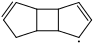

Molecule SMILES: [CH]1C=CC2C1C1CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.824, 233.635, 279.575, 314.386, 367.481, 402.082, 452.918], 'J/(mol*K)'),
    H298 = (201.991, 'kJ/mol'),
    S298 = (0.6276, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 48.277 kcal/mol
S298 = 0.15 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2C1C1CC=CC21.
Molecule [CH]1C=CC2C1C1C=CCC21 has a single polycyclic group match in thermo estimate.


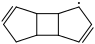

Molecule SMILES: [CH]1C=CC2C1C1C=CCC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.824, 233.635, 279.575, 314.386, 367.481, 402.082, 452.918], 'J/(mol*K)'),
    H298 = (201.991, 'kJ/mol'),
    S298 = (0.6276, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 48.277 kcal/mol
S298 = 0.15 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2C1C1C=CCC21.
pdt8
Species has 3 resonance isomers
Molecule [CH]1C=CC2C=CCC2C=C1 has a single polycyclic group match in therm

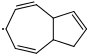

Molecule SMILES: [CH]1C=CC2C=CCC2C=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([176.105, 227.317, 270.747, 304.888, 356.184, 391.413, 445.178], 'J/(mol*K)'),
    H298 = (266.968, 'kJ/mol'),
    S298 = (163.385, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 63.807 kcal/mol
S298 = 39.05 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2C=CCC2C=C1.
Molecule [CH]1C=CC=CC2C=CCC12 has a single polycyclic group match in thermo estimate.


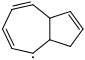

Molecule SMILES: [CH]1C=CC=CC2C=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.431, 234.89, 276.73, 309.742, 358.778, 392.585, 442.332], 'J/(mol*K)'),
    H298 = (288.265, 'kJ/mol'),
    S298 = (147.821, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 68.897 kcal/mol
S298 = 35.33 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC=CC2C=CCC12.
Molecule [CH]1C=CC=CC2CC=CC12 has a single polycyclic group match in thermo estimate.


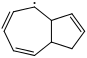

Molecule SMILES: [CH]1C=CC=CC2CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.155, 231.877, 276.06, 309.114, 359.447, 393.212, 442.96], 'J/(mol*K)'),
    H298 = (288.432, 'kJ/mol'),
    S298 = (155.017, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 68.937 kcal/mol
S298 = 37.05 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC=CC2CC=CC12.
pdt10bis
Species has 2 resonance isomers
Molecule [CH]1C=CCC2C=CC=CC12 has a single polycyclic group match in 

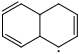

Molecule SMILES: [CH]1C=CCC2C=CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.155, 231.877, 276.06, 309.114, 359.447, 393.212, 442.96], 'J/(mol*K)'),
    H298 = (285.922, 'kJ/mol'),
    S298 = (155.017, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 68.337 kcal/mol
S298 = 37.05 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CCC2C=CC=CC12.
Molecule [CH]1C=CC2C=CC=CC2C1 has a single polycyclic group match in thermo estimate.


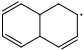

Molecule SMILES: [CH]1C=CC2C=CC=CC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.431, 234.89, 277.148, 309.742, 358.778, 392.585, 442.332], 'J/(mol*K)'),
    H298 = (286.801, 'kJ/mol'),
    S298 = (147.821, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 68.547 kcal/mol
S298 = 35.33 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2C=CC=CC2C1.
pdt11
Species has 1 resonance isomers
Molecule C1=CCC2C=CC=CC2=C1 has a single polycyclic group mat

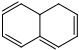

Molecule SMILES: C1=CCC2C=CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([190.037, 241.752, 281.541, 310.662, 352.376, 381.288, 424.509], 'J/(mol*K)'),
    H298 = (226.354, 'kJ/mol'),
    S298 = (125.562, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1=CCC2C=CC=CC2=C1.
pdt17
Species has 2 resonance isomers
Molecule [CH]1C=CC2(C=CC=CC2)C1 has a single polycyclic group match in t

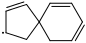

Molecule SMILES: [CH]1C=CC2(C=CC=CC2)C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([183.05, 236.773, 280.244, 314.26, 363.924, 397.062, 442.625], 'J/(mol*K)'),
    H298 = (273.412, 'kJ/mol'),
    S298 = (146.984, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsCs) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 65.347 kcal/mol
S298 = 35.13 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2(C=CC=CC2)C1.
Molecule [CH]1C=CCC12C=CC=CC2 has a single polycyclic group match in thermo estimate.


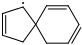

Molecule SMILES: [CH]1C=CCC12C=CC=CC2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([181.46, 236.396, 280.537, 314.846, 364.552, 397.647, 443.086], 'J/(mol*K)'),
    H298 = (274.123, 'kJ/mol'),
    S298 = (148.574, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsCs) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 65.517 kcal/mol
S298 = 35.51 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CCC12C=CC=CC2.
pdt19
Species has 2 resonance isomers
Molecule [CH]1C=CC2CC=CC=C2C1 has a single polycyclic group 

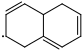

Molecule SMILES: [CH]1C=CC2CC=CC=C2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.606, 236.731, 278.11, 310.578, 359.029, 392.836, 442.04], 'J/(mol*K)'),
    H298 = (281.11, 'kJ/mol'),
    S298 = (152.842, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 67.187 kcal/mol
S298 = 36.53 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2CC=CC=C2C1.
Molecule [CH]1C=CCC2=CC=CCC12 has a single polycyclic group match in thermo estimate.


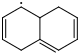

Molecule SMILES: [CH]1C=CCC2=CC=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([180.163, 233.844, 277.064, 309.825, 359.406, 393.38, 442.374], 'J/(mol*K)'),
    H298 = (281.487, 'kJ/mol'),
    S298 = (160.122, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 67.277 kcal/mol
S298 = 38.27 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CCC2=CC=CCC12.
pdt21
Species has 4 resonance isomers
Molecule CC1C=CC=C2[CH]C=CC21 has a single polycyclic 

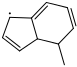

Molecule SMILES: CC1C=CC=C2[CH]C=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (236.383, 'kJ/mol'),
    S298 = (140.695, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 56.497 kcal/mol
S298 = 33.6268305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=CC=C2[CH]C=CC21.
Molecule CC1C=C[CH]C2=CC=CC21 has a single polycyclic group match in thermo estimate.


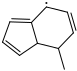

Molecule SMILES: CC1C=C[CH]C2=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (236.383, 'kJ/mol'),
    S298 = (140.695, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 56.497 kcal/mol
S298 = 33.6268305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=C[CH]C2=CC=CC21.
Molecule CC1C=CC=C2C=C[CH]C21 has a single polycyclic group match in thermo estimate.


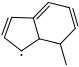

Molecule SMILES: CC1C=CC=C2C=C[CH]C21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.891, 240.58, 285.014, 317.064, 365.096, 397.396, 445.805], 'J/(mol*K)'),
    H298 = (245.505, 'kJ/mol'),
    S298 = (131.03, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 58.677 kcal/mol
S298 = 31.3168305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=CC=C2C=C[CH]C21.
Molecule CC1[CH]C=CC2=CC=CC21 has a single polycyclic group match in thermo estimate

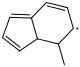

Molecule SMILES: CC1[CH]C=CC2=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([191.167, 243.592, 285.684, 317.691, 364.426, 396.769, 445.178], 'J/(mol*K)'),
    H298 = (256.634, 'kJ/mol'),
    S298 = (123.833, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 61.337 kcal/mol
S298 = 29.5968305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1[CH]C=CC2=CC=CC21.
pdt22
Species has 1 resonance isomers
Molecule C1C=CC2C=CC=C2C=1 has a single polyc

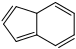

Molecule SMILES: C1C=CC2C=CC=C2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([165.394, 210.623, 244.471, 268.864, 303.8, 327.9, 364.385], 'J/(mol*K)'),
    H298 = (252.588, 'kJ/mol'),
    S298 = (89.6213, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 60.37 kcal/mol
S298 = 21.42 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1C=CC2C=CC=C2C=1.
pdt23
Species has 2 resonance isomers
Molecule [CH]1C=CC2C=CC=CCC12 has a single polycyclic group match in thermo estimate.


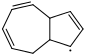

Molecule SMILES: [CH]1C=CC2C=CC=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.431, 234.89, 276.73, 309.742, 358.778, 392.585, 442.332], 'J/(mol*K)'),
    H298 = (274.458, 'kJ/mol'),
    S298 = (147.821, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 65.597 kcal/mol
S298 = 35.33 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2C=CC=CCC12.
Molecule [CH]1C=CC2CC=CC=CC12 has a single polycyclic group match in thermo estimate.


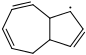

Molecule SMILES: [CH]1C=CC2CC=CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.155, 231.877, 276.06, 309.114, 359.447, 393.212, 442.96], 'J/(mol*K)'),
    H298 = (274.625, 'kJ/mol'),
    S298 = (155.017, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic([CH]1C=CC2C=CCC2C=C1) + radical(cyclopentene-allyl)',
)
H298 = 65.637 kcal/mol
S298 = 37.05 cal/mol*K
Matched polycyclic group "[CH]1C=CC2C=CCC2C=C1"
pdt24
Species has 2 resonance isomers
Molecule [CH]1C=CCC23CC=CC2C13 has a single polycyclic group match in thermo estimate.


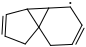

Molecule SMILES: [CH]1C=CCC23CC=CC2C13
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.13, 238.153, 284.47, 320.118, 372.585, 406.266, 453.044], 'J/(mol*K)'),
    H298 = (209.606, 'kJ/mol'),
    S298 = (-5.81576, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsCs) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 50.097 kcal/mol
S298 = -1.39 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CCC23CC=CC2C13.
Molecule [CH]1C=CC2C3C=CCC23C1 has a single polycyclic group match in thermo estimate.


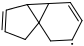

Molecule SMILES: [CH]1C=CC2C3C=CCC23C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.13, 238.153, 284.889, 320.118, 372.585, 406.266, 453.044], 'J/(mol*K)'),
    H298 = (210.652, 'kJ/mol'),
    S298 = (-5.81576, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsCs) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 50.347 kcal/mol
S298 = -1.39 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2C3C=CCC23C1.
pdt26
Species has 1 resonance isomers
Molecule C1=CCC2=CC=CCC2=C1 has a single polycyclic group match in therm

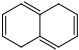

Molecule SMILES: C1=CCC2=CC=CCC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([185.602, 240.831, 281.5, 310.62, 352.711, 381.999, 424.258], 'J/(mol*K)'),
    H298 = (223.76, 'kJ/mol'),
    S298 = (136.649, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 53.48 kcal/mol
S298 = 32.66 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1=CCC2=CC=CCC2=C1.
pdt27
Species has 3 resonance isomers
Molecule CC1C=C[CH]C2C=CCC=21 has a single polycyclic group match in

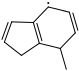

Molecule SMILES: CC1C=C[CH]C2C=CCC=21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.849, 237.986, 280.705, 313.549, 361.79, 395.765, 447.437], 'J/(mol*K)'),
    H298 = (233.413, 'kJ/mol'),
    S298 = (144.502, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 55.787 kcal/mol
S298 = 34.5368305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=C[CH]C2C=CCC=21.
Molecule CC1C=CC=C2C=CC[C]21 has a single polycyclic group match in thermo estimate.


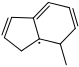

Molecule SMILES: CC1C=CC=C2C=CC[C]21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([183.845, 238.237, 282.253, 314.344, 362.878, 395.681, 447.06], 'J/(mol*K)'),
    H298 = (250.107, 'kJ/mol'),
    S298 = (131.532, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_T)',
)
H298 = 59.777 kcal/mol
S298 = 31.4368305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=CC=C2C=CC[C]21.
Molecule CC1[CH]C=CC2C=CCC=21 has a single polycyclic group match in thermo estimate.


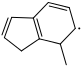

Molecule SMILES: CC1[CH]C=CC2C=CCC=21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([175.184, 228.154, 271.918, 305.976, 358.234, 393.589, 446.433], 'J/(mol*K)'),
    H298 = (273.83, 'kJ/mol'),
    S298 = (138.31, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 65.447 kcal/mol
S298 = 33.0568305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1[CH]C=CC2C=CCC=21.
pdt28
Species has 1 resonance isomers
Molecule C1C=CC2C=CC[C]2CC=1 has a single polycycl

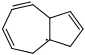

Molecule SMILES: C1C=CC2C=CC[C]2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([187.611, 232.128, 270.579, 302.085, 350.41, 384.719, 435.889], 'J/(mol*K)'),
    H298 = (333.871, 'kJ/mol'),
    S298 = (185.686, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Tertalkyl)',
)
H298 = 79.797 kcal/mol
S298 = 44.38 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1C=CC2C=CC[C]2CC=1.
pdt29
Species has 4 resonance isomers
Molecule [CH]1C=CCC2CC=CC2=C1 has a single polycyclic group match in th

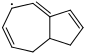

Molecule SMILES: [CH]1C=CCC2CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([177.694, 233.258, 277.901, 311.624, 361.707, 395.639, 447.604], 'J/(mol*K)'),
    H298 = (245.295, 'kJ/mol'),
    S298 = (157.82, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 58.627 kcal/mol
S298 = 37.72 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CCC2CC=CC2=C1.
Molecule [CH]1C=C2C=CC=CCC2C1 has a single polycyclic group match in thermo estimate.


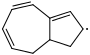

Molecule SMILES: [CH]1C=C2C=CC=CCC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.021, 240.831, 284.303, 316.478, 364.301, 396.811, 444.759], 'J/(mol*K)'),
    H298 = (253.831, 'kJ/mol'),
    S298 = (142.256, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 60.667 kcal/mol
S298 = 34.0 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=C2C=CC=CCC2C1.
Molecule [CH]1C=CC=C2C=CCC2C1 has a single polycyclic group match in thermo estimate.


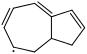

Molecule SMILES: [CH]1C=CC=C2C=CCC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.021, 240.831, 284.303, 316.478, 364.301, 396.811, 444.759], 'J/(mol*K)'),
    H298 = (267.638, 'kJ/mol'),
    S298 = (142.256, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 63.967 kcal/mol
S298 = 34.0 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC=C2C=CCC2C1.
Molecule C1C=C[C]2C=CCC2CC=1 has a single polycyclic group match in thermo estimate.


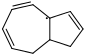

Molecule SMILES: C1C=C[C]2C=CCC2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([187.611, 232.128, 270.579, 302.085, 350.41, 384.719, 435.889], 'J/(mol*K)'),
    H298 = (333.871, 'kJ/mol'),
    S298 = (185.686, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(C1C=CC2C=CC[C]2CC=1) + radical(Tertalkyl)',
)
H298 = 79.797 kcal/mol
S298 = 44.38 cal/mol*K
Matched polycyclic group "C1C=CC2C=CC[C]2CC=1"
pdt30
Species has 1 resonance isomers
Molecule C1C=CC2=CC=CC2CC=1 has a single polycyclic group match in thermo estimate.


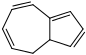

Molecule SMILES: C1C=CC2=CC=CC2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([190.037, 241.752, 281.541, 310.662, 352.376, 381.288, 424.509], 'J/(mol*K)'),
    H298 = (226.354, 'kJ/mol'),
    S298 = (125.562, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1C=CC2=CC=CC2CC=1.
pdt31
Species has 1 resonance isomers
Molecule C1=CC=C2C=CCC2C=C1 has a single polycyclic group match in therm

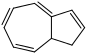

Molecule SMILES: C1=CC=C2C=CCC2C=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([190.037, 241.752, 281.541, 310.662, 352.376, 381.288, 424.509], 'J/(mol*K)'),
    H298 = (226.354, 'kJ/mol'),
    S298 = (125.562, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1=CC=C2C=CCC2C=C1.
pdt32
Species has 4 resonance isomers
Molecule CC1C=CC2=C[CH]C=CC21 has a single polycyclic group match in the

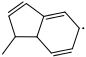

Molecule SMILES: CC1C=CC2=C[CH]C=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (237.848, 'kJ/mol'),
    S298 = (139.398, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 56.847 kcal/mol
S298 = 33.3168305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=CC2=C[CH]C=CC21.
Molecule CC1[CH]C=C2C=CC=CC21 has a single polycyclic group match in thermo estimate.


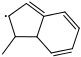

Molecule SMILES: CC1[CH]C=C2C=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([191.167, 243.592, 285.684, 317.691, 364.426, 396.769, 445.178], 'J/(mol*K)'),
    H298 = (245.337, 'kJ/mol'),
    S298 = (123.833, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 58.637 kcal/mol
S298 = 29.5968305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1[CH]C=C2C=CC=CC21.
Molecule CC1C=CC2=CC=C[CH]C21 has a single polycyclic group match in thermo estima

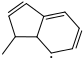

Molecule SMILES: CC1C=CC2=CC=C[CH]C21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.891, 240.58, 285.014, 317.064, 365.096, 397.396, 445.805], 'J/(mol*K)'),
    H298 = (259.312, 'kJ/mol'),
    S298 = (131.03, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 61.977 kcal/mol
S298 = 31.3168305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=CC2=CC=C[CH]C21.
Molecule CC1C=C[C]2C=CC=CC21 has a single polycyclic group match in thermo estimate.


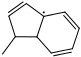

Molecule SMILES: CC1C=C[C]2C=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.481, 231.877, 271.709, 302.671, 351.205, 385.305, 436.935], 'J/(mol*K)'),
    H298 = (326.59, 'kJ/mol'),
    S298 = (174.46, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Tertalkyl)',
)
H298 = 78.057 kcal/mol
S298 = 41.6968305179 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for CC1C=C[C]2C=CC=CC21.
pdt35
Species has 1 resonance isomers
Molecule C1C=CC2C=CCC=2CC=1 has a single polycyclic group match 

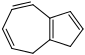

Molecule SMILES: C1C=CC2C=CCC=2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([173.887, 226.438, 267.399, 298.821, 345.891, 378.024, 425.471], 'J/(mol*K)'),
    H298 = (241.249, 'kJ/mol'),
    S298 = (140.122, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 57.66 kcal/mol
S298 = 33.49 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1C=CC2C=CCC=2CC=1.
pdt37
Species has 3 resonance isomers
Molecule [CH]1C=CC2CC=CCC2=C1 has a single polycyclic group matc

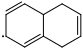

Molecule SMILES: [CH]1C=CC2CC=CCC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.113, 229.283, 271.751, 305.599, 356.142, 391.581, 444.592], 'J/(mol*K)'),
    H298 = (262.533, 'kJ/mol'),
    S298 = (168.49, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 62.747 kcal/mol
S298 = 40.27 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for [CH]1C=CC2CC=CCC2=C1.
Molecule C1C=CC2CC=CC[C]2C=1 has a single polycyclic group match in thermo estimate.


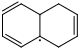

Molecule SMILES: C1C=CC2CC=CC[C]2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([177.109, 229.534, 273.299, 306.394, 357.23, 391.497, 444.215], 'J/(mol*K)'),
    H298 = (279.228, 'kJ/mol'),
    S298 = (155.519, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_T)',
)
H298 = 66.737 kcal/mol
S298 = 37.17 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1C=CC2CC=CC[C]2C=1.
Molecule [CH]1C=CC=C2CC=CCC12 has a single polycyclic group match in thermo estimate.


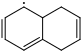

Molecule SMILES: [CH]1C=CC=C2CC=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([180.163, 233.844, 277.064, 309.825, 359.406, 393.38, 442.374], 'J/(mol*K)'),
    H298 = (283.997, 'kJ/mol'),
    S298 = (160.122, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic([CH]1C=CC2CC=CC=C2C1) + radical(Allyl_S)',
)
H298 = 67.877 kcal/mol
S298 = 38.27 cal/mol*K
Matched polycyclic group "[CH]1C=CC2CC=CC=C2C1"
pdt38
Species has 3 resonance isomers
Molecule C1=CCc2ccccc2C1 has a single polycyclic group match in thermo estimate.


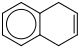

Molecule SMILES: C1=CCc2ccccc2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([149.118, 199.242, 242.839, 278.32, 331.875, 369.112, 422.835], 'J/(mol*K)'),
    H298 = (137.319, 'kJ/mol'),
    S298 = (212.045, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cb-Cs) + other(R) + group(Cb-Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 32.82 kcal/mol
S298 = 50.68 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1=CCc2ccccc2C1.
Molecule C1=CC=C2CC=CCC2=C1 has a single polycyclic group match in thermo estimate.


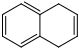

Molecule SMILES: C1=CC=C2CC=CCC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([185.602, 240.831, 281.5, 310.62, 352.711, 381.999, 424.258], 'J/(mol*K)'),
    H298 = (223.76, 'kJ/mol'),
    S298 = (136.649, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 53.48 kcal/mol
S298 = 32.66 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1=CC=C2CC=CCC2=C1.
Molecule C1C=CC2CC=CCC=2C=1 has a single polycyclic group match in thermo estimate.


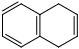

Molecule SMILES: C1C=CC2CC=CCC=2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([185.602, 240.831, 281.5, 310.62, 352.711, 381.999, 424.258], 'J/(mol*K)'),
    H298 = (223.76, 'kJ/mol'),
    S298 = (136.649, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 53.48 kcal/mol
S298 = 32.66 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1C=CC2CC=CCC=2C=1.
INDENE
Species has 2 resonance isomers
Molecule C1=Cc2ccccc2C1 has a single polycyclic group match in ther

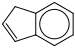

Molecule SMILES: C1=Cc2ccccc2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([119.118, 159.661, 197.401, 230.287, 278.403, 306.813, 353.171], 'J/(mol*K)'),
    H298 = (157.235, 'kJ/mol'),
    S298 = (334.971, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cb-Cs) + other(R) + group(Cb-(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cb-H) + other(R) + group(Cds-CdsCbH) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + polycyclic(indene)',
)
H298 = 37.58 kcal/mol
S298 = 80.06 cal/mol*K
Matched polycyclic group "indene"
Molecule C1=CC=C2CC=CC2=C1 has a single polycyclic group match in thermo estimate.


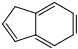

Molecule SMILES: C1=CC=C2CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([156.733, 204.347, 240.12, 266.353, 304.47, 329.825, 368.234], 'J/(mol*K)'),
    H298 = (245.517, 'kJ/mol'),
    S298 = (82.8432, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 58.68 kcal/mol
S298 = 19.8 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1=CC=C2CC=CC2=C1.
pdt57
Species has 1 resonance isomers
Molecule C=CC=CC1C2[CH]C=CC21 has a single polycyclic group match in thermo estimate.


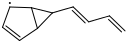

Molecule SMILES: C=CC=CC1C2[CH]C=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([179.661, 233.844, 278.362, 311.457, 361.581, 394.844, 444.55], 'J/(mol*K)'),
    H298 = (276.843, 'kJ/mol'),
    S298 = (145.687, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-CdsHH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 66.167 kcal/mol
S298 = 34.82 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C=CC=CC1C2[CH]C=CC21.
2HINDENE
Species has 1 resonance isomers
Molecule C1C=CC2=CCC=C2C=1 has a single polycyclic group match i

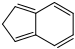

Molecule SMILES: C1C=CC2=CCC=C2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([145.017, 189.954, 226.02, 254.555, 297.65, 325.85, 369.447], 'J/(mol*K)'),
    H298 = (264.471, 'kJ/mol'),
    S298 = (85.0189, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 63.21 kcal/mol
S298 = 20.32 cal/mol*K
Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for C1C=CC2=CCC=C2C=1.


In [6]:
for label, entry in thermoLibrary.entries.iteritems():
    molecule = entry.item
    libraryThermoData = entry.data
    if molecule.getAllPolycyclicVertices():
        print label
        species = Species(molecule=[molecule])
        species.generateResonanceIsomers() 
        print 'Species has {0} resonance isomers'.format(len(species.molecule))
        estimatedThermo = thermoDatabase.getThermoDataFromGroups(species)
        
        estimatedThermos = [thermoDatabase.estimateThermoViaGroupAdditivity(molecule) for molecule in species.molecule]
        for estimatedThermo in estimatedThermos:
            index = estimatedThermos.index(estimatedThermo)
            tokens = estimatedThermo.comment.split()
            polycyclicGroups = []
            for token in tokens:
                if 'polycyclic' in token:
                    splitTokens = re.split("\(|\)",token)
                    assert len(splitTokens) == 3
                    groupLabel = splitTokens[1]
                    polycyclicGroups.append(thermoDatabase.groups['polycyclic'].entries[groupLabel])

            if len(polycyclicGroups) == 0:
                raise Exception('Species {0} detected as polycyclic but estimated thermo contained no polycyclic groups: \
                        you need to create a new polycyclic group'.format(label))

            elif len(polycyclicGroups) == 1:
                polycyclicGroup = polycyclicGroups[0]
                print 'Molecule {0} has a single polycyclic group match in thermo estimate.'.format(species.molecule[index].toSMILES())
                # Draw the molecule in ipython notebook
                display(species.molecule[index])
                print 'Molecule SMILES: {0}'.format(species.molecule[index].toSMILES())
                print 'Estimated thermo data:'
                print prettify(repr(estimatedThermo))
                displayThermo(estimatedThermo)

                withoutPolycyclicGroupThermo = removeThermoData(copy.deepcopy(estimatedThermo), polycyclicGroup.data)
                newPolycyclicGroupThermo = removeThermoData(copy.deepcopy(libraryThermoData), withoutPolycyclicGroupThermo)


                # Check to make sure that the polycyclic group is not generic
                # If it is, create a new polycyclicGroup as the child
                if polycyclicGroup.label == 'PolycyclicRing':
                    print 'Polycyclic group was found to be generic "PolycyclicRing". Creating new entry for {0}.'.format(species.molecule[index].toSMILES())
                    groups = extractPolycyclicGroups(molecule)
                    assert len(groups) == 1
                    # Create a new entry in the polycyclic groups with the same name as the thermo library entry
                    # Make sure it does not already exist
                    if label not in thermoDatabase.groups['polycyclic'].entries:
                        entryLabel = species.molecule[index].toSMILES()
                    else:
                        raise Exception('Found a label collision with a previous SMILES, but the estimate should have matched the group.')
                    thermoDatabase.groups['polycyclic'].entries[entryLabel] = Entry(index = len(thermoDatabase.groups['polycyclic'].entries)+1,
                                                                              label = entryLabel,
                                                                               item = groups[0],
                                                                               data = polycyclicGroup.data, # Use dummy thermo here so other estimates can find this group
                                                                               parent = polycyclicGroup,
                                                                              )

                    # Set the new entry as the polycyclicGroup and make it a child of the generic group
                    polycyclicGroup = thermoDatabase.groups['polycyclic'].entries[entryLabel] 
                    thermoDatabase.groups['polycyclic'].entries['PolycyclicRing'].children.append(polycyclicGroup)
                    

                else:
                    print 'Matched polycyclic group "{0}"'.format(polycyclicGroup.label)





                # Add the new group value to the fitting dictionary
                if polycyclicGroup not in fittingDictionary:
                    # Add a tuple containing fitted group data, the original library entry, and thermo library
                    fittingDictionary[polycyclicGroup]=[(newPolycyclicGroupThermo, entry, thermoLibrary)]
                else:
                    fittingDictionary[polycyclicGroup].append((newPolycyclicGroupThermo, entry, thermoLibrary))

            elif len(polycyclicGroups) > 1:
                print 'Species {0} has matched multiple polycyclic groups. \
                        This cannot be fitted with a single molecule\'s thermo data.'.format(label)
                raise Exception
        print '====================='

In [7]:
for polycyclicGroup, fittingGroups in fittingDictionary.iteritems():
    print 'Original thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    if polycyclicGroup.data:
        print prettify(repr(polycyclicGroup.data))
    else:
        print 'No data found. Was created as a new group.'
    
    thermoDataset = [fitTuple[0] for fitTuple in fittingGroups]
    labels = [fitTuple[1].label for fitTuple in fittingGroups]
    libraryLabels = [fitTuple[2].name for fitTuple in fittingGroups]
    # Average the new group values to fit the original polycyclic group
    fittedGroupData = averageThermoData([fitTuple[0] for fitTuple in fittingGroups])
    #print fittedGroupData
    #print fittingGroups
    polycyclicGroup.data = fittedGroupData
    polycyclicGroup.shortDesc = "Fitted from thermo library values"
    
    comment = ''
    for i in range(len(labels)):
        comment += "Fitted from species {0} from {1} library.\n".format(labels[i],libraryLabels[i])
    polycyclicGroup.longDesc = comment.strip()
    
    print 'Fitted thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    print prettify(repr(polycyclicGroup.data))
    print polycyclicGroup.longDesc
    print '===================================================================='
    # At this point, save and overwrite the entire polycyclic thermo library

thermoDatabase.groups['polycyclic'].save('new_polycyclic.py')

Original thermo data for polycyclic group: CC1C=CC=C2[CH]C=CC21
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([0, 0, 0, 0, 0, 0, 0], 'cal/(mol*K)'),
    H298 = (0, 'kcal/mol'),
    S298 = (0, 'cal/(mol*K)'),
    comment = 'polycyclic(PolycyclicRing)',
)
Averaging thermo data over 1 value(s).
Fitted thermo data for polycyclic group: CC1C=CC=C2[CH]C=CC21
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([-6.68, -6.81, -6.56, -5.84, -4.8, -3.99, -3.4], 'cal/(mol*K)'),
    H298 = (6.863, 'kcal/mol'),
    S298 = (57.6932, 'cal/(mol*K)'),
)
Fitted from species pdt21 from C10H11 library.
Original thermo data for polycyclic group: C1C=CC2=CCC=C2C=1
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([0, 0, 0, 0, 0, 0, 0], 'cal/(mol*K)'),
    H298 = (0, 'kcal/mol'),
    S298 = (0, 'cal/(mol*K)'),
    comment = 'polycyclic(PolycyclicRing)',
)
Averaging thermo data over 1 value(s).
Fitted therm

In [8]:
def compareThermoData(thermoData1, thermoData2):
    delH = thermoData1.H298.value_si - thermoData2.H298.value_si
    print 'Difference in H298 = {0} kcal/mol'.format(delH/4184)
    delS = thermoData1.S298.value_si - thermoData2.S298.value_si
    print 'Difference S298 = {0} cal/mol*K'.format(delS/4.184)
    Tdata = [300,500,1000,2000]
    for T in Tdata:
        delCp = thermoData1.getHeatCapacity(T) - thermoData2.getHeatCapacity(T)
        print 'Difference in Cp at {0} = {1} cal/mol*K'.format(T, delCp/4.184)

pdt7


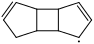

Species has 2 resonance isomers
Library thermo data for species pdt7 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([34.78, 48.21, 59.54, 68.55, 81.61, 90.58, 103.73], 'cal/(mol*K)'),
    H298 = (85.78, 'kcal/mol'),
    S298 = (89.07, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 85.78 kcal/mol
S298 = 89.07 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.824, 233.635, 279.575, 314.386, 367.481, 402.082, 452.918], 'J/(mol*K)'),
    H298 = (201.991, 'kJ/mol'),
    S298 = (0.6276, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds

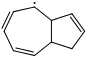

Species has 3 resonance isomers
Library thermo data for species pdt8 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([35.78, 48.52, 59.38, 68.18, 81.16, 90.2, 103.52], 'cal/(mol*K)'),
    H298 = (78.78, 'kcal/mol'),
    S298 = (91.18, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 78.78 kcal/mol
S298 = 91.18 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([176.105, 227.317, 270.747, 304.888, 356.184, 391.413, 445.178], 'J/(mol*K)'),
    H298 = (266.968, 'kJ/mol'),
    S298 = (163.385, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) 

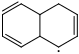

Species has 2 resonance isomers
Library thermo data for species pdt10bis does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([36.17, 48.88, 59.7, 68.46, 81.4, 90.4, 103.65], 'cal/(mol*K)'),
    H298 = (76.28, 'kcal/mol'),
    S298 = (89.92, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 76.28 kcal/mol
S298 = 89.92 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.155, 231.877, 276.06, 309.114, 359.447, 393.212, 442.96], 'J/(mol*K)'),
    H298 = (285.922, 'kJ/mol'),
    S298 = (155.017, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + g

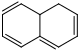

Species has 1 resonance isomers
Library thermo data for species pdt11 matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([34.42, 46.5, 56.8, 65.16, 77.52, 86.1, 98.67], 'cal/(mol*K)'),
    H298 = (63.19, 'kcal/mol'),
    S298 = (87.27, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
)
H298 = 63.19 kcal/mol
S298 = 87.27 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([144.013, 194.556, 237.651, 272.629, 324.344, 360.242, 412.835], 'J/(mol*K)'),
    H298 = (264.387, 'kJ/mol'),
    S298 = (365.138, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(C

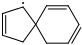

Species has 2 resonance isomers
Library thermo data for species pdt17 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([37.03, 49.77, 60.5, 69.12, 81.79, 90.61, 103.67], 'cal/(mol*K)'),
    H298 = (80.09, 'kcal/mol'),
    S298 = (92.88, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 80.09 kcal/mol
S298 = 92.88 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([183.05, 236.773, 280.244, 314.26, 363.924, 397.062, 442.625], 'J/(mol*K)'),
    H298 = (273.412, 'kJ/mol'),
    S298 = (146.984, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsCs) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + gr

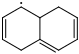

Species has 2 resonance isomers
Library thermo data for species pdt19 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([36.33, 48.88, 59.6, 68.33, 81.28, 90.32, 103.62], 'cal/(mol*K)'),
    H298 = (74.88, 'kcal/mol'),
    S298 = (91.27, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 74.88 kcal/mol
S298 = 91.27 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.606, 236.731, 278.11, 310.578, 359.029, 392.836, 442.04], 'J/(mol*K)'),
    H298 = (281.11, 'kJ/mol'),
    S298 = (152.842, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R)

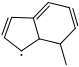

Species has 4 resonance isomers
Library thermo data for species pdt21 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([37.02, 49.6, 60.29, 68.93, 81.68, 90.56, 103.68], 'cal/(mol*K)'),
    H298 = (63.36, 'kcal/mol'),
    S298 = (91.32, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (503.026, 'J/(mol*K)'),
)
H298 = 63.36 kcal/mol
S298 = 91.32 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (236.383, 'kJ/mol'),
    S298 = (140.695, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (503.026, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R

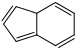

Species has 1 resonance isomers
Library thermo data for species pdt22 matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([29.9, 40.53, 49.39, 56.44, 66.66, 73.66, 83.86], 'cal/(mol*K)'),
    H298 = (74.42, 'kcal/mol'),
    S298 = (81.81, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (407.409, 'J/(mol*K)'),
)
H298 = 74.42 kcal/mol
S298 = 81.81 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([125.102, 169.578, 206.648, 236.145, 278.905, 308.193, 350.87], 'J/(mol*K)'),
    H298 = (311.373, 'kJ/mol'),
    S298 = (342.293, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (407.409, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group

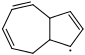

Species has 2 resonance isomers
Library thermo data for species pdt23 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([36.31, 49.05, 59.86, 68.59, 81.45, 90.4, 103.6], 'cal/(mol*K)'),
    H298 = (83.25, 'kcal/mol'),
    S298 = (91.39, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 83.25 kcal/mol
S298 = 91.39 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([148.239, 206.606, 255.057, 293.215, 348.339, 385.765, 440.073], 'J/(mol*K)'),
    H298 = (273.403, 'kJ/mol'),
    S298 = (347.439, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + g

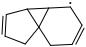

Species has 2 resonance isomers
Library thermo data for species pdt24 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([35.9, 48.9, 59.87, 68.68, 81.59, 90.53, 103.69], 'cal/(mol*K)'),
    H298 = (82.04, 'kcal/mol'),
    S298 = (88.96, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 82.04 kcal/mol
S298 = 88.96 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([150.206, 204.598, 250.914, 287.357, 341.373, 378.778, 433.839], 'J/(mol*K)'),
    H298 = (344.301, 'kJ/mol'),
    S298 = (372.209, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsCs) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds

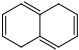

Species has 1 resonance isomers
Library thermo data for species pdt26 matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([34.85, 46.73, 56.9, 65.2, 77.52, 86.1, 98.68], 'cal/(mol*K)'),
    H298 = (63.81, 'kcal/mol'),
    S298 = (86.13, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
)
H298 = 63.81 kcal/mol
S298 = 86.13 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([145.812, 195.518, 238.07, 272.797, 324.344, 360.242, 412.877], 'J/(mol*K)'),
    H298 = (266.981, 'kJ/mol'),
    S298 = (360.368, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other

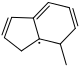

Species has 3 resonance isomers
Library thermo data for species pdt27 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([37.3, 49.7, 60.28, 68.87, 81.62, 90.53, 103.69], 'cal/(mol*K)'),
    H298 = (62.67, 'kcal/mol'),
    S298 = (92.61, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (503.026, 'J/(mol*K)'),
)
H298 = 62.67 kcal/mol
S298 = 92.61 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.849, 237.986, 280.705, 313.549, 361.79, 395.765, 447.437], 'J/(mol*K)'),
    H298 = (233.413, 'kJ/mol'),
    S298 = (144.502, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (503.026, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + o

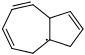

Species has 1 resonance isomers
Library thermo data for species pdt28 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([36.48, 48.92, 59.63, 68.36, 81.35, 90.42, 103.73], 'cal/(mol*K)'),
    H298 = (94.43, 'kcal/mol'),
    S298 = (93.22, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 94.43 kcal/mol
S298 = 93.22 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([151.419, 203.844, 248.906, 285.558, 339.971, 377.899, 433.63], 'J/(mol*K)'),
    H298 = (332.816, 'kJ/mol'),
    S298 = (385.305, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + 

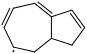

Species has 4 resonance isomers
Library thermo data for species pdt29 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([35.9, 48.52, 59.35, 68.14, 81.16, 90.22, 103.55], 'cal/(mol*K)'),
    H298 = (64.66, 'kcal/mol'),
    S298 = (90.96, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 64.66 kcal/mol
S298 = 90.96 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([177.694, 233.258, 277.901, 311.624, 361.707, 395.639, 447.604], 'J/(mol*K)'),
    H298 = (245.295, 'kJ/mol'),
    S298 = (157.82, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(

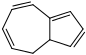

Species has 1 resonance isomers
Library thermo data for species pdt30 matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([34.58, 46.66, 56.96, 65.3, 77.6, 86.14, 98.66], 'cal/(mol*K)'),
    H298 = (68.39, 'kcal/mol'),
    S298 = (88.24, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
)
H298 = 68.39 kcal/mol
S298 = 88.24 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([144.683, 195.225, 238.321, 273.215, 324.678, 360.41, 412.793], 'J/(mol*K)'),
    H298 = (286.144, 'kJ/mol'),
    S298 = (369.196, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(C

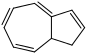

Species has 1 resonance isomers
Library thermo data for species pdt31 matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([34.48, 46.59, 56.91, 65.26, 77.59, 86.13, 98.67], 'cal/(mol*K)'),
    H298 = (65.83, 'kcal/mol'),
    S298 = (87.99, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
)
H298 = 65.83 kcal/mol
S298 = 87.99 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([144.264, 194.933, 238.111, 273.048, 324.637, 360.368, 412.835], 'J/(mol*K)'),
    H298 = (275.433, 'kJ/mol'),
    S298 = (368.15, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group

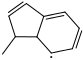

Species has 4 resonance isomers
Library thermo data for species pdt32 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([36.79, 49.32, 60.02, 68.69, 81.53, 90.47, 103.66], 'cal/(mol*K)'),
    H298 = (62.33, 'kcal/mol'),
    S298 = (91.53, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (503.026, 'J/(mol*K)'),
)
H298 = 62.33 kcal/mol
S298 = 91.53 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (237.848, 'kJ/mol'),
    S298 = (139.398, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (503.026, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(

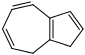

Species has 1 resonance isomers
Library thermo data for species pdt35 matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([35.04, 47.01, 57.21, 65.5, 77.74, 86.25, 98.74], 'cal/(mol*K)'),
    H298 = (65.78, 'kcal/mol'),
    S298 = (88.09, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
)
H298 = 65.78 kcal/mol
S298 = 88.09 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([146.607, 196.69, 239.367, 274.052, 325.264, 360.87, 413.128], 'J/(mol*K)'),
    H298 = (275.224, 'kJ/mol'),
    S298 = (368.569, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + othe

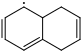

Species has 3 resonance isomers
Library thermo data for species pdt37 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([35.83, 48.48, 59.3, 68.09, 81.13, 90.21, 103.57], 'cal/(mol*K)'),
    H298 = (64.94, 'kcal/mol'),
    S298 = (89.18, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
H298 = 64.94 kcal/mol
S298 = 89.18 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.113, 229.283, 271.751, 305.599, 356.142, 391.581, 444.592], 'J/(mol*K)'),
    H298 = (262.533, 'kJ/mol'),
    S298 = (168.49, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cd

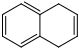

Species has 3 resonance isomers
Library thermo data for species pdt38 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([33.96, 45.89, 56.19, 64.61, 77.13, 85.83, 98.55], 'cal/(mol*K)'),
    H298 = (35.66, 'kcal/mol'),
    S298 = (86.59, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
)
H298 = 35.66 kcal/mol
S298 = 86.59 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([149.118, 199.242, 242.839, 278.32, 331.875, 369.112, 422.835], 'J/(mol*K)'),
    H298 = (137.319, 'kJ/mol'),
    S298 = (212.045, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (482.239, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cb-Cs) + other(R) + group(Cb-Cs) + other(R) + group(Cds-CdsCsH) + other

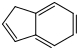

Species has 2 resonance isomers
Library thermo data for species INDENE matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([29.28, 39.78, 48.65, 55.78, 66.17, 73.3, 83.68], 'cal/(mol*K)'),
    H298 = (40.49, 'kcal/mol'),
    S298 = (79.82, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (407.409, 'J/(mol*K)'),
)
H298 = 40.49 kcal/mol
S298 = 79.82 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([122.508, 166.44, 203.552, 233.384, 276.855, 306.687, 350.117], 'J/(mol*K)'),
    H298 = (169.41, 'kJ/mol'),
    S298 = (333.967, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (407.409, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) 

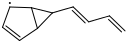

Species has 1 resonance isomers
Library thermo data for species pdt57 matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([39.02, 51.51, 61.97, 70.32, 82.53, 91.05, 103.78], 'cal/(mol*K)'),
    H298 = (100.54, 'kcal/mol'),
    S298 = (95.99, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (498.868, 'J/(mol*K)'),
)
H298 = 100.54 kcal/mol
S298 = 95.99 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([163.26, 215.518, 259.282, 294.219, 345.306, 380.953, 434.216], 'J/(mol*K)'),
    H298 = (420.659, 'kJ/mol'),
    S298 = (401.622, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (498.868, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-

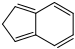

Species has 1 resonance isomers
Library thermo data for species 2HINDENE matches the estimate from group additivity.
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([30.17, 40.65, 49.4, 56.39, 66.59, 73.6, 83.82], 'cal/(mol*K)'),
    H298 = (62.6, 'kcal/mol'),
    S298 = (79.2, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (407.409, 'J/(mol*K)'),
)
H298 = 62.6 kcal/mol
S298 = 79.2 cal/mol*K
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([126.231, 170.08, 206.69, 235.936, 278.613, 307.942, 350.703], 'J/(mol*K)'),
    H298 = (261.918, 'kJ/mol'),
    S298 = (331.373, 'J/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (407.409, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other

In [9]:
# Test that the new group additivity values can estimate the old library ones exactly.

for label, entry in thermoLibrary.entries.iteritems():
    molecule = entry.item
    libraryThermoData = entry.data
    
    if molecule.getAllPolycyclicVertices():
        species = Species(molecule=[molecule])
        species.generateResonanceIsomers()
        print label
        display (species.molecule[0])
        print 'Species has {0} resonance isomers'.format(len(species.molecule))
        thermoDatabase.findCp0andCpInf(species, libraryThermoData)
        estimatedThermo = thermoDatabase.getThermoDataFromGroups(species)
        if libraryThermoData.isIdenticalTo(estimatedThermo):
            print 'Library thermo data for species {0} matches the estimate from group additivity.'.format(label)
            print 'Library thermo data:'
            print prettify(repr(libraryThermoData))
            displayThermo(libraryThermoData)
            print 'Estimated thermo data:'
            print prettify(repr(estimatedThermo))
            displayThermo(estimatedThermo)
        else:
            print 'Library thermo data for species {0} does not match the estimate from group additivity'.format(label)
            print 'Library thermo data:'
            print prettify(repr(libraryThermoData))
            displayThermo(libraryThermoData)
            print 'Estimated thermo data:'
            print prettify(repr(estimatedThermo))
            displayThermo(estimatedThermo)
            compareThermoData(libraryThermoData,estimatedThermo)
        print '======================='

In [ ]:
# pdt32 debug
m = Molecule(SMILES='CC1C=CC2=CC=CCC21')
s = Species(molecule=[m])
s.generateResonanceIsomers()
print s.molecule
thermoDatabase.groups['polycyclic'].descendTree(m,{},None)